# Coordinate Transform

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
R_LONG = 6378137
R_SHORT = 6356752.3142
E_EARTH: np.float64 = np.sqrt(1 - (R_SHORT / R_LONG) ** 2)

# MEAN_ALTITUDE = 12.711403


def lla_to_ecef(lon_rad, lat_rad, alt):
    N = R_LONG / np.sqrt(1 - E_EARTH ** 2 * np.sin(lat_rad))
    return (
        (N + alt) * np.cos(lat_rad) * np.cos(lon_rad),
        (N + alt) * np.cos(lat_rad) * np.sin(lon_rad),
        (N * (R_LONG / R_SHORT) ** 2 + alt) * np.sin(lat_rad),
    )

## Data Loading

In [3]:
lla_labels = ["gps_latitude", "gps_longitude", "gps_altitude"]
# lla_labels = [label[:7] + "_integrated" for label in lla_labels]

csv_paths = [
    # "../local/log/1128/车头x正向/tracking_control_node.csv",
    # "../local/log/1128/手动行驶1/tracking_control_node.csv",
    # "../local/log/1127/asc_1226/手动采集融合定位/tracking_control_node.csv",
    # "../local/log/1127/asc_1226/1127-恒温区直行/tracking_control_node.csv",
    # "../local/log/1127/asc_1226/1127-恒温区转弯1/tracking_control_node.csv",
    # "../local/log/1127/asc_1226/1127-恒温区转弯4/tracking_control_node.csv",
    # "../local/log/1126/asc_log/tracking_control_node.csv",
    # "../local/log/1128/手动行驶全场/tracking_control_node.csv",
    "./coordinate_transform.csv",
]

df_log = pd.concat([
    pd.read_csv(path, index_col=0) for path in csv_paths
])
df_src = df_log.loc[
    (df_log["valid"] == 1)
    & (df_log[lla_labels[0]] != 0)
    & (df_log[lla_labels[1]] != 0)
    & (df_log[lla_labels[2]] != 0)
    & ((df_log["x_center"] != df_log["x_estimate"])
        | (df_log["y_center"] != df_log["y_estimate"]))
    & np.isfinite(df_log[lla_labels[0]])
    & np.isfinite(df_log[lla_labels[1]])
    & np.isfinite(df_log[lla_labels[2]])
    & ((df_log["x_center"] >= 560) | (df_log["y_center"] >= 90))
]
n_src = len(df_src)
print(f"{n_src} out of {len(df_log)} samples selected")

lat = df_src[lla_labels[0]].to_numpy()
lon = df_src[lla_labels[1]].to_numpy()
alt = df_src[lla_labels[2]].to_numpy()
heading = df_src["heading"].to_numpy()
x_center = df_src["x_center"].to_numpy()
y_center = df_src["y_center"].to_numpy()

column_shape = (n_src, 1)
lat_rad = np.deg2rad(lat)
lon_rad = np.deg2rad(lon)

4168 out of 50470 samples selected


In [4]:
# i_0 = 0
i_0 = n_src // 2
# lat0_rad, lon0_rad, alt0 = \
#     lat_rad[i_0], lon_rad[i_0], alt[i_0]
lat0_rad, lon0_rad, alt0 = \
    lat_rad.mean(), lon_rad.mean(), alt.mean()
ecef_x0, ecef_y0, ecef_z0 = \
    lla_to_ecef(lon0_rad, lat0_rad, alt0)


def ecef_to_enu(lon_rad, lat_rad, ecef_x, ecef_y, ecef_z):
    ecef_dx = ecef_x - ecef_x0
    ecef_dy = ecef_y - ecef_y0
    ecef_dz = ecef_z - ecef_z0
    e = -np.sin(lon_rad) * ecef_dx + np.cos(lon_rad) * ecef_dy
    n = -np.cos(lon_rad) * np.sin(lat_rad) * ecef_dx \
        - np.sin(lon_rad) * np.sin(lat_rad) * ecef_dy \
        + np.cos(lat_rad) * ecef_dz
    u = np.cos(lon_rad) * np.cos(lat_rad) * ecef_dx \
        + np.sin(lon_rad) * np.cos(lat_rad) * ecef_dy \
        + np.sin(lat_rad) * ecef_dz
    return e, n, u

### Original LLA

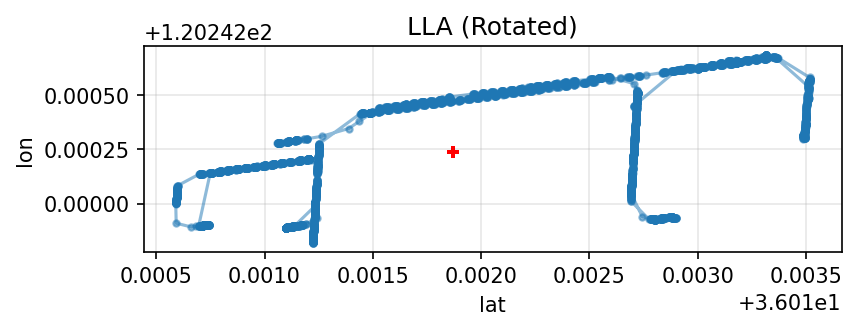

In [5]:
fig = plt.figure(figsize=(6, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ll = np.vstack([lat, lon])
ll_0 = np.array([ll[:, 0].tolist()] * ll.shape[1]).T
rotation = np.deg2rad(180 - 50)
R = np.array([
    [np.cos(rotation), -np.sin(rotation)],
    [np.sin(rotation), np.cos(rotation)],
])
ll_rotated = R @ (ll - ll_0) + ll_0
ax.plot(ll_rotated[0, :], ll_rotated[1, :], ".-", alpha=0.5)

ll_origin = np.vstack([np.rad2deg(lat0_rad), np.rad2deg(lon0_rad)])
ll_origin_rotated = R @ (ll_origin - ll_0) + ll_0
ax.plot(ll_origin_rotated[0, :], ll_origin_rotated[1, :], "r+",
        label="LLA Origin")

ax.set(
    title="LLA (Rotated)",
    xlabel="lat",
    ylabel="lon",
    aspect="equal",
)
ax.grid(alpha=0.3)

### Original ECEF

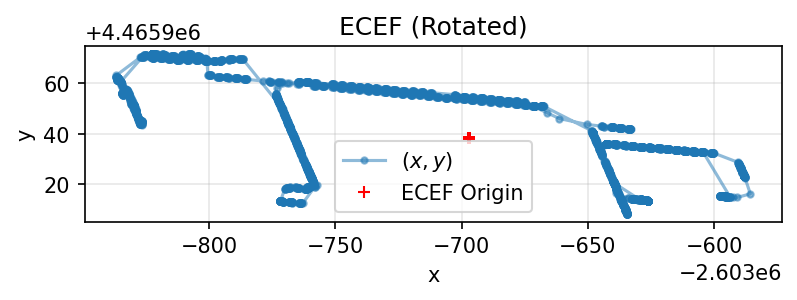

In [6]:
fig = plt.figure(figsize=(6, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ecef_x, ecef_y, ecef_z = \
    lla_to_ecef(lon_rad, lat_rad, alt)
ecef = np.vstack([ecef_x, ecef_y])
ecef_0 = np.array([ecef[:, 0].tolist()] * ecef.shape[1]).T
rotation = np.deg2rad(120)
R = np.array([
    [np.cos(rotation), -np.sin(rotation)],
    [np.sin(rotation), np.cos(rotation)],
])
ecef_rotated = R @ (ecef - ecef_0) + ecef_0
ax.plot(ecef_rotated[0, :], ecef_rotated[1, :], ".-", alpha=0.5, label="$(x,y)$")

ecef_origin = np.vstack([ecef_x0, ecef_y0])
ecef_origin_rotated = R @ (ecef_origin - ecef_0) + ecef_0
ax.plot(ecef_origin_rotated[0, :], ecef_origin_rotated[1, :], "r+", \
        label="ECEF Origin")

ax.set(
    title="ECEF (Rotated)",
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend(loc="lower center")
ax.grid(alpha=0.3)

### Original ENU

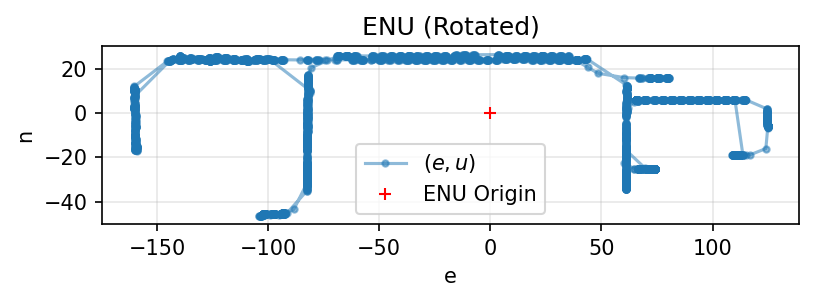

In [7]:
fig = plt.figure(figsize=(6, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

e, n, u = ecef_to_enu(lon_rad, lat_rad, ecef_x, ecef_y, ecef_z)
en = np.vstack([e, n])
rotation = np.deg2rad(-38)
R = np.array([
    [np.cos(rotation), -np.sin(rotation)],
    [np.sin(rotation), np.cos(rotation)],
])
en_rotated = R @ en
ax.plot(en_rotated[0, :], en_rotated[1, :], ".-", alpha=0.5, label="$(e,u)$")

ax.plot(0, 0, "r+", label="ENU Origin")

ax.set(
    title="ENU (Rotated)",
    xlabel="e",
    ylabel="n",
    aspect="equal",
)
ax.legend(loc="lower center")
ax.grid(alpha=0.3)

## Estimate Device Offset

Solution =
[[ 4.83636116e-01 -3.11663418e+00]
 [ 3.17459003e+00  5.40240370e-01]
 [ 7.88427401e-01 -6.13230935e-01]
 [ 6.10387839e-01  7.78994608e-01]
 [-1.97252277e-01  1.98377900e-01]
 [ 8.68350497e-06 -5.88701423e-07]
 [-2.20736353e-03  1.68622810e-03]
 [ 8.79591621e-04  6.22270781e-04]
 [ 6.87425025e+02  1.09312610e+02]]
Residuals =
[356.68211115 445.37547293]
Rank =
9
Singular Values =
[3.27574100e+05 1.52392175e+04 5.49596913e+03 5.44405110e+03
 1.28396679e+03 6.91903178e+01 4.61380345e+01 2.68549193e+01
 1.53483127e+01]
Condition Number =
21342.678194339234
Estimated Device Offset =
(0.511938, 3.145612)


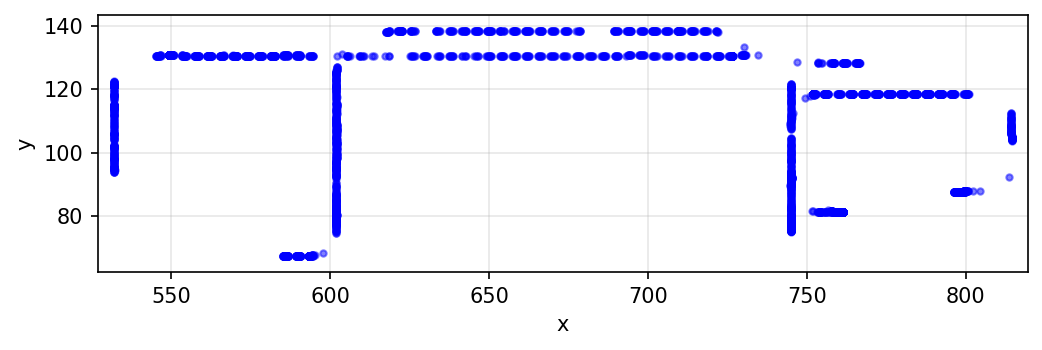

In [8]:
MODEL_DEGREE = 1.5

A_est = np.hstack([
    np.cos(heading).reshape(column_shape),
    np.sin(heading).reshape(column_shape),
    e.reshape(column_shape),
    n.reshape(column_shape),
    u.reshape(column_shape),
    *(
        [
            (e * n).reshape(column_shape),
            (n * u).reshape(column_shape),
            (u * e).reshape(column_shape),
        ]
        if MODEL_DEGREE >= 1.5
        else []
    ),
    *(
        [
            (e ** 2).reshape(column_shape),
            (n ** 2).reshape(column_shape),
            (u ** 2).reshape(column_shape),
        ]
        if MODEL_DEGREE >= 2
        else []
    ),
    np.ones(column_shape),
])
b_est = np.hstack([
    x_center.reshape(column_shape),
    y_center.reshape(column_shape),
])

# estimation_slice = (x_center >= 620) & (x_center <= 720)
# A_est = np.compress(estimation_slice, A_est, axis=0)
# b_est = np.compress(estimation_slice, b_est, axis=0)

(
    solution_est,
    residuals_est,
    rank_est,
    singular_values_est
) = np.linalg.lstsq(A_est, b_est)
estimated_device_x = (np.abs(solution_est[0, 0]) + np.abs(solution_est[1, 1])) / 2
estimated_device_y = (np.abs(solution_est[1, 0]) + np.abs(solution_est[0, 1])) / 2
print("Solution =")
print(solution_est)
print("Residuals =")
print(residuals_est)
print("Rank =")
print(rank_est)
print("Singular Values =")
print(singular_values_est)
print("Condition Number =")
print(singular_values_est[0] / singular_values_est[-1])
print("Estimated Device Offset =")
print(f"({estimated_device_x:.6f}, {estimated_device_y:.6f})")

fig = plt.figure(figsize=(8, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(b_est[:, 0].ravel(), b_est[:, 1].ravel(), '.',
        color='blue', alpha=0.5, label='Samples For Estimating Device Offset')

ax.set(
    xlabel="x",
    xlim=(b_est[:, 0].min() - 5, b_est[:, 0].max() + 5),
    ylabel="y",
    ylim=(b_est[:, 1].min() - 5, b_est[:, 1].max() + 5),
    aspect='equal',
)
ax.grid(alpha=0.3)

## Fit Transform Formula

In [9]:
INS_OFFSET_X = 0.465
INS_OFFSET_Y = 2.950
INS_OFFSET_X = estimated_device_x
INS_OFFSET_Y = estimated_device_y
# INS_OFFSET_X = 0
# INS_OFFSET_Y = 0


def center_to_ins(center_x, center_y, heading):
    offset_x = INS_OFFSET_X * np.cos(heading) - INS_OFFSET_Y * np.sin(heading)
    offset_y = INS_OFFSET_X * np.sin(heading) + INS_OFFSET_Y * np.cos(heading)
    return center_x + offset_x, center_y + offset_y


def ins_to_center(ins_x, ins_y, heading):
    offset_x = INS_OFFSET_X * np.cos(heading) - INS_OFFSET_Y * np.sin(heading)
    offset_y = INS_OFFSET_X * np.sin(heading) + INS_OFFSET_Y * np.cos(heading)
    return ins_x - offset_x, ins_y - offset_y

### INS Ground Truth

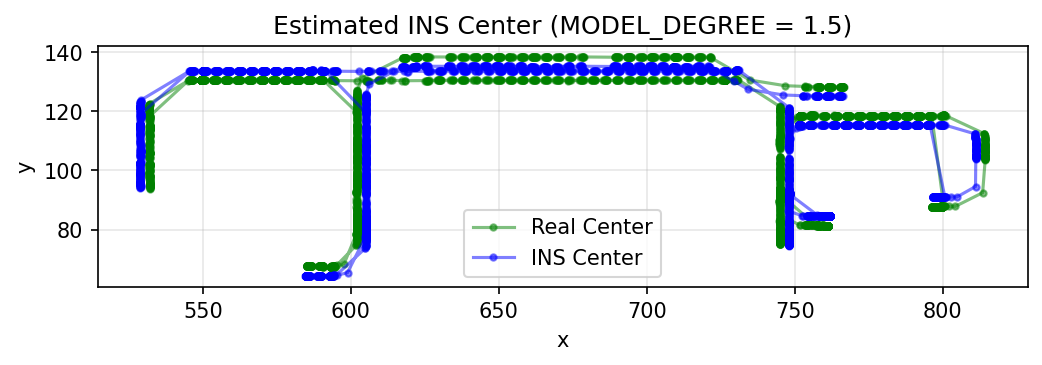

In [10]:
x_ins, y_ins = center_to_ins(x_center, y_center, heading)

fig = plt.figure(figsize=(8, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(x_center, y_center, "g.-", alpha=0.5, label="Real Center")
ax.plot(x_ins, y_ins, "b.-", alpha=0.5, label="INS Center")

# x_center_recovered, y_center_recovered = \
#     ins_to_center(x_ins, y_ins, heading)
# ax.plot(x_center_recovered, y_center_recovered, "y-",
#         alpha=0.5, label="Recovered Center")

ax.set(
    title=f"Estimated INS Center (MODEL_DEGREE = {MODEL_DEGREE})",
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend(loc="lower center")
ax.grid(alpha=0.3)

### Fitted Result

Solution =
[[ 6.87536115e+02  1.08596184e+02]
 [ 7.89918277e-01 -6.18264990e-01]
 [ 6.09474826e-01  7.88027482e-01]
 [-2.36295772e-01  2.34559052e-01]
 [-2.01836642e-05  1.09658679e-04]
 [-5.48694641e-03  3.84567597e-03]
 [ 3.71893479e-03 -1.96675328e-04]]
Residuals =
[2463.28140073 1019.04598765]
Rank =
7
Singular Values =
[3.27574100e+05 1.52392110e+04 5.49591562e+03 5.44405008e+03
 1.28394183e+03 6.57032412e+01 1.93100919e+01]
Condition Number =
16963.88088958957


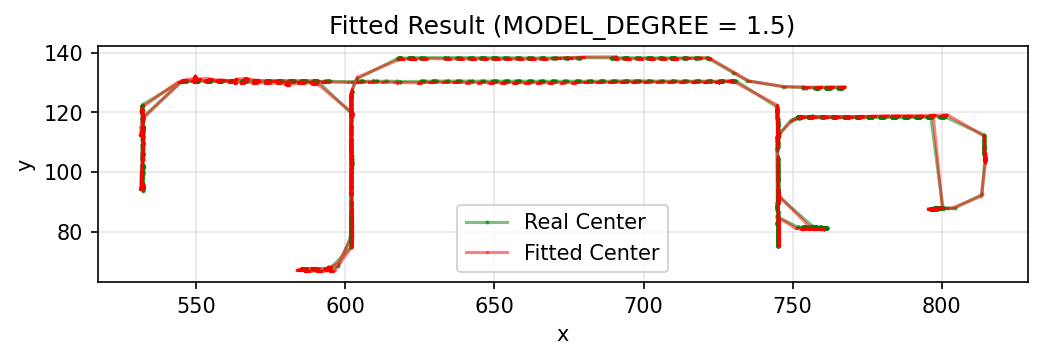

In [11]:
A_fit = np.hstack([
    np.ones(column_shape),
    e.reshape(column_shape),
    n.reshape(column_shape),
    u.reshape(column_shape),
    *(
        [
            (e * n).reshape(column_shape),
            (n * u).reshape(column_shape),
            (u * e).reshape(column_shape),
        ]
        if MODEL_DEGREE >= 1.5
        else []
    ),
    *(
        [
            (e ** 2).reshape(column_shape),
            (n ** 2).reshape(column_shape),
            (u ** 2).reshape(column_shape),
        ]
        if MODEL_DEGREE >= 2
        else []
    ),
])
b_fit = np.hstack([
    x_ins.reshape(column_shape),
    y_ins.reshape(column_shape),
])
(
    solution_fit,
    residuals_fit,
    rank_fit,
    singular_values_fit
) = np.linalg.lstsq(A_fit, b_fit)
print("Solution =")
print(solution_fit)
print("Residuals =")
print(residuals_fit)
print("Rank =")
print(rank_fit)
print("Singular Values =")
print(singular_values_fit)
print("Condition Number =")
print(singular_values_fit[0] / singular_values_fit[-1])

ins_fitted = A_fit @ solution_fit
x_ins_fitted = ins_fitted[:, 0].ravel()
y_ins_fitted = ins_fitted[:, 1].ravel()
x_center_fitted, y_center_fitted = \
    ins_to_center(x_ins_fitted, y_ins_fitted, heading)

fig = plt.figure(figsize=(8, 8), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(x_center, y_center, "g.-", ms=2, alpha=0.5, label="Real Center")
ax.plot(x_center_fitted, y_center_fitted, "r.-", ms=1,
        alpha=0.5, label="Fitted Center")

ax.set(
    title=f"Fitted Result (MODEL_DEGREE = {MODEL_DEGREE})",
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend(loc="lower center")
ax.grid(alpha=0.3)

P(dis < 1) = 0.6725047984644914
               dis
count  4168.000000
mean      0.849935
std       0.336346
min       0.047870
25%       0.634561
50%       0.836014
75%       1.049475
max       2.152986


,x_center,y_center,x_center_fitted,y_center_fitted,dis
3073,582.73,130.56,580.991058,129.290580,2.152986
3064,582.07,130.54,580.302836,129.323554,2.145369
3068,582.41,130.55,580.678930,129.316672,2.125489
3061,581.93,130.53,580.207460,129.308975,2.111409
3072,582.65,130.56,580.959529,129.295227,2.111243
3066,582.29,130.54,580.563342,129.332959,2.106727
3063,582.02,130.54,580.302836,129.323554,2.104374
3070,582.52,130.55,580.816013,129.315759,2.104026
3067,582.37,130.55,580.678930,129.316672,2.093040
3065,582.25,130.54,580.563342,129.332959,2.074070


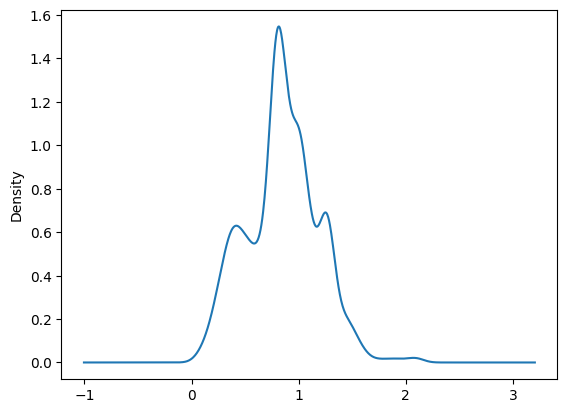

In [12]:
df_comp = pd.DataFrame({
    "x_center": x_center,
    "y_center": y_center,
    "x_center_fitted": x_center_fitted,
    "y_center_fitted": y_center_fitted,
})
dis = np.sqrt(
    (x_center_fitted - x_center) ** 2 + (y_center_fitted - y_center) ** 2
)
df_comp["dis"] = dis

threshold = 1
print(f"P(dis < {threshold}) =", (dis < threshold).sum() / len(dis))

print(df_comp[["dis"]].describe())

df_comp["dis"].plot.density()

df_comp.sort_values(by="dis", ascending=False, inplace=True)
df_comp.head(10)

### C++ Code

In [13]:
print("// 参考坐标")
print(f"const static double ORIGIN_LAT = {np.rad2deg(lat0_rad):.12f}; // ENU 参考点纬度")
print(f"const static double ORIGIN_LON = {np.rad2deg(lon0_rad):.12f}; // ENU 参考点经度")
print(f"const static double ORIGIN_ALT = {alt0:.12f}; // ENU 参考点海拔")
print(f"const double INS_OFFSET_X = {INS_OFFSET_X:.12f}; // 定位点在车身坐标系下的 X 坐标")
print(f"const double INS_OFFSET_Y = {INS_OFFSET_Y:.12f}; // 定位点在车身坐标系下的 Y 坐标")
print()
print("// 计算车辆中心坐标")
print(
    (
        "center_x = %.12f"
        "\n    + INS_OFFSET_X * -cos_heading"
        "\n    + INS_OFFSET_Y * sin_heading"
        "\n    + %.12f * enu_x"
        "\n    + %.12f * enu_y"
        "\n    + %.12f * enu_z"
        + (
            "\n    + %.12f * (enu_x * enu_y)"
            "\n    + %.12f * (enu_y * enu_z)"
            "\n    + %.12f * (enu_z * enu_x)"
            if MODEL_DEGREE >= 1.5
            else ""
        )
        + (
            "\n    + %.12f * pow(enu_x, 2)"
            "\n    + %.12f * pow(enu_y, 2)"
            "\n    + %.12f * pow(enu_z, 2)"
            if MODEL_DEGREE >= 2
            else ""
        )
        + ";"
    )
    % tuple(solution_fit[:, 0].ravel())
)
print(
    (
        "center_y = %.12f"
        "\n    + INS_OFFSET_X * -sin_heading"
        "\n    + INS_OFFSET_Y * -cos_heading"
        "\n    + %.12f * enu_x"
        "\n    + %.12f * enu_y"
        "\n    + %.12f * enu_z"
        + (
            "\n    + %.12f * (enu_x * enu_y)"
            "\n    + %.12f * (enu_y * enu_z)"
            "\n    + %.12f * (enu_z * enu_x)"
            if MODEL_DEGREE >= 1.5
            else ""
        )
        + (
            "\n    + %.12f * pow(enu_x, 2)"
            "\n    + %.12f * pow(enu_y, 2)"
            "\n    + %.12f * pow(enu_z, 2)"
            if MODEL_DEGREE >= 2
            else ""
        )
        + ";"
    )
    % tuple(solution_fit[:, 1].ravel())
)

// 参考坐标
const static double ORIGIN_LAT = 36.010801995801; // ENU 参考点纬度
const static double ORIGIN_LON = 120.241669950312; // ENU 参考点经度
const static double ORIGIN_ALT = 10.989486564299; // ENU 参考点海拔
const double INS_OFFSET_X = 0.511938243037; // 定位点在车身坐标系下的 X 坐标
const double INS_OFFSET_Y = 3.145612105461; // 定位点在车身坐标系下的 Y 坐标

// 计算车辆中心坐标
center_x = 687.536114629993
    + INS_OFFSET_X * -cos_heading
    + INS_OFFSET_Y * sin_heading
    + 0.789918276523 * enu_x
    + 0.609474825749 * enu_y
    + -0.236295772317 * enu_z
    + -0.000020183664 * (enu_x * enu_y)
    + -0.005486946410 * (enu_y * enu_z)
    + 0.003718934791 * (enu_z * enu_x);
center_y = 108.596183544605
    + INS_OFFSET_X * -sin_heading
    + INS_OFFSET_Y * -cos_heading
    + -0.618264990381 * enu_x
    + 0.788027481693 * enu_y
    + 0.234559052464 * enu_z
    + 0.000109658679 * (enu_x * enu_y)
    + 0.003845675972 * (enu_y * enu_z)
    + -0.000196675328 * (enu_z * enu_x);


## Reproduction of Fusion Localization

### Module Translated

In [14]:
from typing import cast


class FusionLocalization:

    N_STATE: int
    N_OBSERVATIONS: int
    state: np.ndarray
    P: np.ndarray
    Q: np.ndarray
    Q0: np.ndarray
    R: np.ndarray
    last_time: np.int64
    time_intervals: list[np.float64]
    last_velocity_x: np.float64
    last_velocity_y: np.float64
    noise_factor: np.float64
    record: pd.Series
    init_finished: bool

    def __init__(self) -> None:
        N_STATE = 5
        N_OBSERVATIONS = 4
        self.N_STATE = N_STATE
        self.N_OBSERVATIONS = N_OBSERVATIONS
        self.state = np.zeros((N_STATE,))
        self.P = np.zeros((N_STATE, N_STATE))
        self.Q = np.zeros((N_STATE, N_STATE))
        self.R = np.zeros((N_OBSERVATIONS, N_OBSERVATIONS))
        self.error_history = []
        self.last_time = np.int64(0)
        self.time_intervals = []
        self.last_velocity_x = np.float64(0)
        self.last_velocity_y = np.float64(0)
        self.noise_factor = np.float64(1)
        self.init_finished = False

    def lla_to_center(
        self,
        lat: np.float64,
        lon: np.float64,
        alt: np.float64,
    ) -> tuple[np.float64, np.float64]:
        lat_rad = np.deg2rad(lat)
        lon_rad = np.deg2rad(lon)
        ecef = lla_to_ecef(lon_rad, lat_rad, alt)
        e, n, u = ecef_to_enu(lon_rad, lat_rad, *ecef)
        A = np.array([
            [
                1,
                e, n, u,
                *([e * n, n * u, u * e] if MODEL_DEGREE >= 1.5 else []),
                *([e ** 2, n ** 2, u ** 2] if MODEL_DEGREE >= 2 else []),
            ],
        ])
        ins = A @ solution_fit
        assert ins.shape == (1, 2), ins.shape
        heading = self.record["heading"]
        return ins_to_center(ins[0, 0], ins[0, 1], heading)

    def init_process_noise(self) -> None:
        self.Q0 = np.zeros_like(self.Q)
        self.Q0[0, 0] = 0.03  # x 方向位置噪声
        self.Q0[1, 1] = 0.03  # y 方向位置噪声
        self.Q0[2, 2] = 0.01  # 角速度噪声
        self.Q0[3, 3] = 0.1  # 线速度噪声
        self.Q0[4, 4] = 0.1  # 角度噪声
        self.Q = self.Q0

    def init_measurement_noise(self) -> None:
        self.R.fill(0)
        self.R[0, 0] = 0.02  # 磁钉位置 X 坐标的测量噪声
        self.R[1, 1] = 0.02  # 磁钉位置 Y 坐标的测量噪声
        self.R[2, 2] = 0.015  # GNSS 计算出车辆中心在堆场坐标系下 X 坐标的测量噪声
        self.R[3, 3] = 0.015  # GNSS 计算出车辆中心在堆场坐标系下 Y 坐标的测量噪声

    def check_ins_stability(self) -> bool:
        VELOCITY_CHANGE_THRESHOLD = 0.5

        vx = self.record["v_gx"]
        vy = self.record["v_gy"]

        delta_vx = abs(vx - self.last_velocity_x)
        delta_vy = abs(vy - self.last_velocity_y)

        self.last_velocity_x = vx
        self.last_velocity_y = vy

        return bool(
            (delta_vx < VELOCITY_CHANGE_THRESHOLD)
            and (delta_vy < VELOCITY_CHANGE_THRESHOLD)
        )

    def adjust_noise_covariances(self) -> None:
        if not self.check_ins_stability():
            self.noise_factor = np.min([
                self.noise_factor + 0.1,
                np.float64(2.0),
            ])
        else:
            self.noise_factor = np.max([
                self.noise_factor - 0.05,
                np.float64(1.0),
            ])

        self.Q = self.noise_factor * self.Q

    def predict(self, dt: np.float64) -> None:
        state = self.state
        record = self.record

        vx = record["v_gx"]
        vy = record["v_gy"]

        state[0] += vx
        state[1] += vy
        state[3] = vx
        state[4] = vy

        omega_z = record["omega_z"]
        state[2] += omega_z

        if state[2] > np.pi:
            state[2] -= np.pi
        elif state[2] < -np.pi:
            state[2] += np.pi

        F = np.eye(self.N_STATE)
        F[0, 3] = F[1, 4] = dt
        F[2, 2] = 1

        self.P = F @ self.P @ F.T + self.Q

    def update(self, x_gnss: np.float64, y_gnss: np.float64) -> None:
        record = self.record
        state = self.state

        H = np.zeros((self.N_OBSERVATIONS, self.N_STATE))
        H[2, 0] = H[3, 1] = 1
        H[0, 0] = H[1, 1] = 1

        z = np.array([
            record["x_center"],
            record["y_center"],
            x_gnss,
            y_gnss,
        ])
        # if (
        #     (record["x_center"] == record["x_estimate"])
        #     and (record["y_center"] == record["y_estimate"])
        # ):
        #     z[0] = state[0]
        #     z[1] = state[1]

        if not (
            (z[0] >= 0)
            and (z[1] <= 850)
            and (z[2] >= 0)
            and (z[3] <= 850)
        ):
            return

        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        y = z - H @ state

        self.state += K @ y

        I = np.eye(self.N_STATE)
        self.P = (I - K @ H) @ self.P

    def init(self) -> None:
        self.state.fill(0)
        self.P = np.eye(self.N_STATE)
        self.init_process_noise()
        self.init_measurement_noise()

    def cyclic(self, record: pd.Series) -> None:

        self.record = record

        if not self.init_finished:
            if not (
                record["gps_longitude"] > 0
                and record["gps_latitude"] > 0
                and record["gps_altitude"] > 0
            ):
                # print("Waiting for valid gps data.")
                return
            elif not (
                record["valid"] == 1
                and np.isfinite(record["x_center"])
                and np.isfinite(record["y_center"])
                and (
                    (record["x_center"] != record["x_estimate"])
                    or (record["y_center"] != record["y_estimate"])
                )
            ):
                # print("Waiting for transponder correction.")
                return
            else:
                self.init_finished = True
                self.state[0] = record["x_center"]
                self.state[1] = record["y_center"]
                self.state[2] = record["heading"]

        current_time = np.int64(
            cast(pd.Timestamp, pd.to_datetime(record["timestamp"]))
            .to_pydatetime(warn=False)
            .timestamp() * 1000
        )
        if self.last_time == 0:
            self.last_time = current_time
            return

        time_intervals = self.time_intervals
        dt = (current_time - self.last_time) / 1000
        if dt > 0:
            time_intervals.append(dt)
            if len(time_intervals) > 10:
                time_intervals.pop(0)

        averaged_dt = np.float64(1 / 20)
        if len(time_intervals) > 0:
            averaged_dt = np.mean(time_intervals)

        lat = record["gps_latitude"]
        lon = record["gps_longitude"]
        alt = record["gps_altitude"]
        x_gnss, y_gnss = self.lla_to_center(lat, lon, alt)

        self.predict(averaged_dt)
        self.update(x_gnss, y_gnss)

        self.last_time = current_time

        self.adjust_noise_covariances()

### Iteration Replay

In [15]:
fusion_localization = FusionLocalization()
fusion_localization.init()

df_replay = pd.read_csv(
    "./coordinate_transform.csv",
    index_col=0,
)
df_replay["x_replay"] = np.nan
df_replay["y_replay"] = np.nan
df_replay.fillna({ "v_gx": 0, "v_gy": 0 }, inplace=True)

init_count = 0
for i, (index, data) in enumerate(df_replay.iterrows()):

    fusion_localization.cyclic(data)

    if not fusion_localization.init_finished:
        init_count += 1
    else:
        df_replay.at[index, "x_replay"] = fusion_localization.state[0]
        df_replay.at[index, "y_replay"] = fusion_localization.state[1]

n_total = len(df_replay)
print(f"init_count: {init_count} (total: {n_total})")

init_count: 46 (total: 50470)


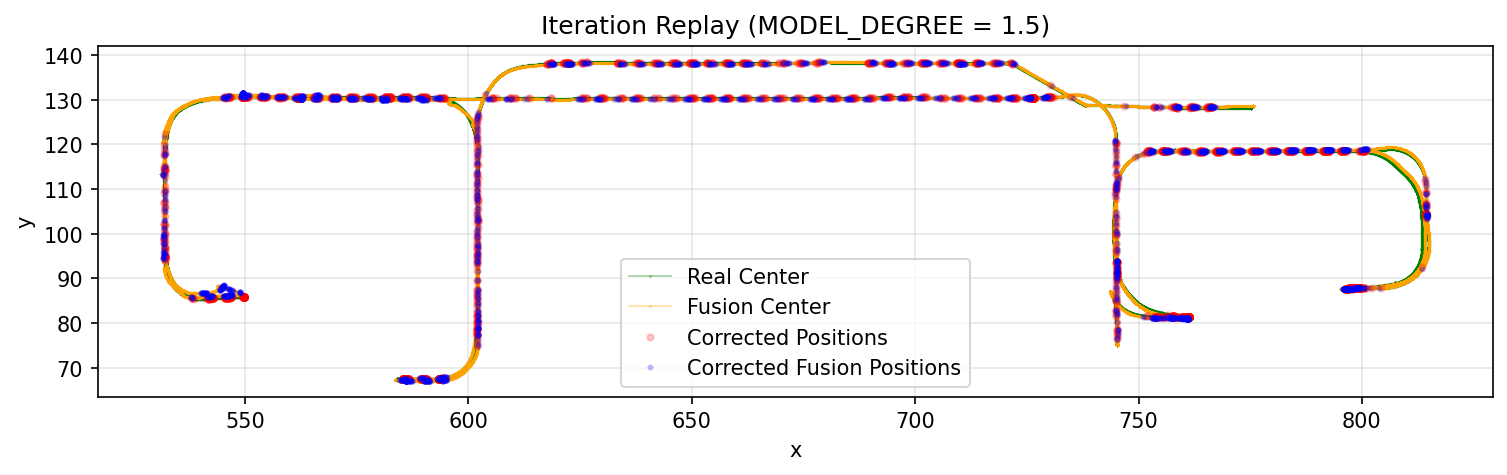

In [16]:
fig = plt.figure(figsize=(12, 10), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

df_replay_masked = df_replay.loc[df_replay["valid"] == 1]
ax.plot(df_replay_masked["x_center"], df_replay_masked["y_center"], ".-",
        ms=1, lw=1, color="green", alpha=0.3, label="Real Center")
ax.plot(df_replay_masked["x_replay"], df_replay_masked["y_replay"], ".-",
        ms=1, lw=1, color="orange", alpha=0.3, label="Fusion Center")

df_corrected = df_replay.loc[
    (df_replay["valid"] == 1)
    & np.isfinite(df_replay["x_center"])
    & np.isfinite(df_replay["y_center"])
    & np.isfinite(df_replay["x_estimate"])
    & np.isfinite(df_replay["y_estimate"])
    & ((df_replay["x_center"] != df_replay["x_estimate"])
       | (df_replay["x_center"] != df_replay["x_estimate"]))
].copy()
ax.plot(df_corrected["x_center"], df_corrected["y_center"], "o",
        ms=3, lw=0, color="red", alpha=0.2, label="Corrected Positions")
ax.plot(df_corrected["x_replay"], df_corrected["y_replay"], "o",
        ms=2, lw=0, color="blue", alpha=0.2, label="Corrected Fusion Positions")

ax.set(
    title=f"Iteration Replay (MODEL_DEGREE = {MODEL_DEGREE})",
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend(loc="lower center")
ax.grid(alpha=0.3)

P(distance < 1.0) = 95.92%
P(distance < 0.9) = 88.89%
P(distance < 0.8) = 82.99%
P(distance < 0.7) = 73.73%
P(distance < 0.6) = 59.28%
P(distance < 0.5) = 40.96%
P(distance < 0.4) = 15.43%
P(distance < 0.3) =  9.60%
P(distance < 0.2) =  5.02%
P(distance < 0.1) =  1.52%


count    2969.000000
mean        0.636356
std         0.543859
min         0.029774
25%         0.453826
50%         0.536466
75%         0.715310
max         5.484080
Name: distance, dtype: float64

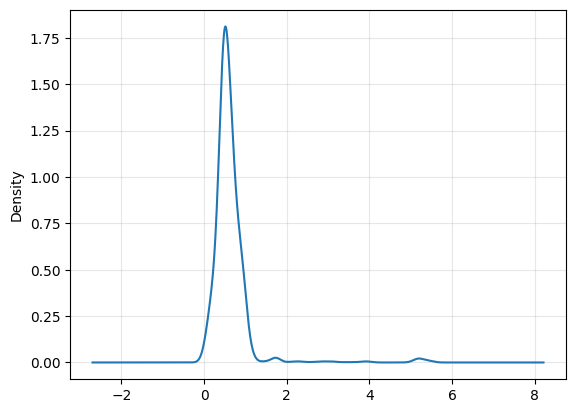

In [17]:
df_corrected["distance"] = np.sqrt(
    (df_corrected["x_replay"] - df_corrected["x_center"]) ** 2
    + (df_corrected["y_replay"] - df_corrected["y_center"]) ** 2
)

df_corrected["distance"].plot(kind="density")
plt.gca().grid(alpha=0.3)

for k in np.arange(1, 0, -0.1):
    print(f"P(distance < {k:3.1f}) = {(df_corrected["distance"] < k).mean():6.2%}")

df_corrected["distance"].describe()